<a href="https://colab.research.google.com/github/choki0715/UnLiteFlowNet-PIV/blob/master/(UGW)DLinear_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<span style="color:#ffd33d; font-size:150%"> 2022.08.9: DLinear Model Demo </span>
# 2022.08.12
RIN
RNN-GRU
# 2022.08.16 test
RIN
comb
ma
GRU
i28o7

# 2022.08.17 test
input&pred seq_size vs moving average kernel size

# 2022.08.18 test
GRU modify

# 2022.08.19 test
Combination parametor
Conv1D multi-variable 
RIN

# 2022.08.22
> MOE

> conv1d -> activation relu()

> prediction linear layer add

# 2022.08.25
> step by step bench mark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NIA 2차 수질예측 프로젝트/dev-models/DLinear

Mounted at /content/drive
/content/drive/MyDrive/NIA 2차 수질예측 프로젝트/dev-models/DLinear


In [ ]:
# import argparse
import os
import os.path as osp
import torch
from exp.exp_main import Exp_Main
import random
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

import seaborn as sns
import IPython
import IPython.display
mpl.rcParams['figure.figsize'] = (16,12)
mpl.rcParams['axes.grid'] = False

# %matplotlib inline

In [ ]:

fix_seed = 2022
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

class args:
    pass

# 'Autoformer & Transformer family for Time Series Forecasting'

args.is_training = 1 #''status')
args.model_id = '(음성대소)UGW_train_20220824_FIX(i56o5ma10)_01(base)' #'model id')
args.model = 'DLinear' #options: [Autoformer, Informer, Transformer, DLinear]'

# data loader
args.data = 'custom'             # 'dataset type'
args.root_path = '/content/drive/MyDrive/NIA 2차 수질예측 프로젝트/원천데이터/(지하수) 전처리, 원천데이터 통합본'  # 'root path of the data file'
args.data_path = 'test_음성대소_기상자료_수위pre_20220805.csv'                                                     # 'data file'
args.features = 'MS'                                                                                               # 'forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate'
args.target = 'OBSR_DTA_VALUE'                                                                                     # 'target feature in S or MS task')
args.freq = 'd'                                                                                                    # 'freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h'
args.checkpoints = './checkpoints/'                                                                                #'location of model checkpoints')

# forecasting task
args.seq_len = 56                                                                                                  # 'input sequence length'
args.label_len = 1                                                                                                 # 'start token length'
args.pred_len = 5          # 5                                                                                        # 'prediction sequence length'

# DLinear
# args.individual = False                                                                                            # 'DLinear: a linear layer for each variate(channel) individually'
args.conv1d = False
args.RIN = False
args.combination = False
args.RNN_lyr = False
args.rnn_stack = 1
args.hidden = 56
args.conv_kernal = 1
args.dropout = 0.05             # 'dropout'


# Formers - 트렌스 포머 계열을 위한 파라메터
args.embed_type = 0             # '0: default 1: value embedding + temporal embedding + positional embedding 2: value embedding + temporal embedding 3: value embedding + positional embedding 4: value embedding')
args.enc_in = 6                 # 'encoder input size') # DLinear with --individual, use this hyperparameter as the number of channels
args.dec_in = 6                 # 'decoder input size'
args.c_out = 1                  # 'output size'
args.d_model = 512              # 'dimension of model'
args.n_heads = 8                # 'num of heads'
args.e_layers = 2               # 'num of encoder layers'
args.d_layers = 1               # 'num of decoder layers'
args.d_ff = 2048                # 'dimension of fcn'

args.moving_avg = 10             # 'window size of moving average'
# args.moving_avg = [3,10,15,20,25,30,35,40]    # 'window size' list of moving average'

args.factor = 1                 # 'attn factor'
args.distil = True              # 'whether to use distilling in encoder, using this argument means not using distilling',
args.embed = 'timeF'            # 'time features encoding, options:[timeF, fixed, learned]'
args.activation = 'relu'        # 'activation'
args.output_attention = True    # action='store_true''whether to output attention in ecoder'
args.do_predict = False         # 'whether to predict unseen future data')

# optimization
args.num_workers =10            # 'data loader num workers'
args.itr = 1                    # 'experiments times'
args.train_epochs = 100          # 'train epochs'
args.batch_size = 5             # 'batch size of train input data'
args.patience = 7               # 'early stopping patience'
# args.learning_rate = 0.0001     # 'optimizer learning rate'
args.learning_rate = 0.01
args.des = 'Exp'                # 'exp description'
args.loss = 'mse'               # 'loss function')
args.lradj = 'type1'            # 'adjust learning rate'
args.use_amp = False            # 'use automatic mixed precision training'

# GPU
args.use_gpu = True             # 'use gpu'
args.gpu = 0                    # 'gpu'
args.use_multi_gpu = False      # 'use multiple gpus'
args.devices = '0,1,2,3'        # 'device ids of multile gpus'
args.test_flop = False          # 'See utils/tools for usage'


args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
if args.use_gpu and args.use_multi_gpu:
    args.dvices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

print('Args in experiment:')
print(args)

Args in experiment:
<class '__main__.args'>


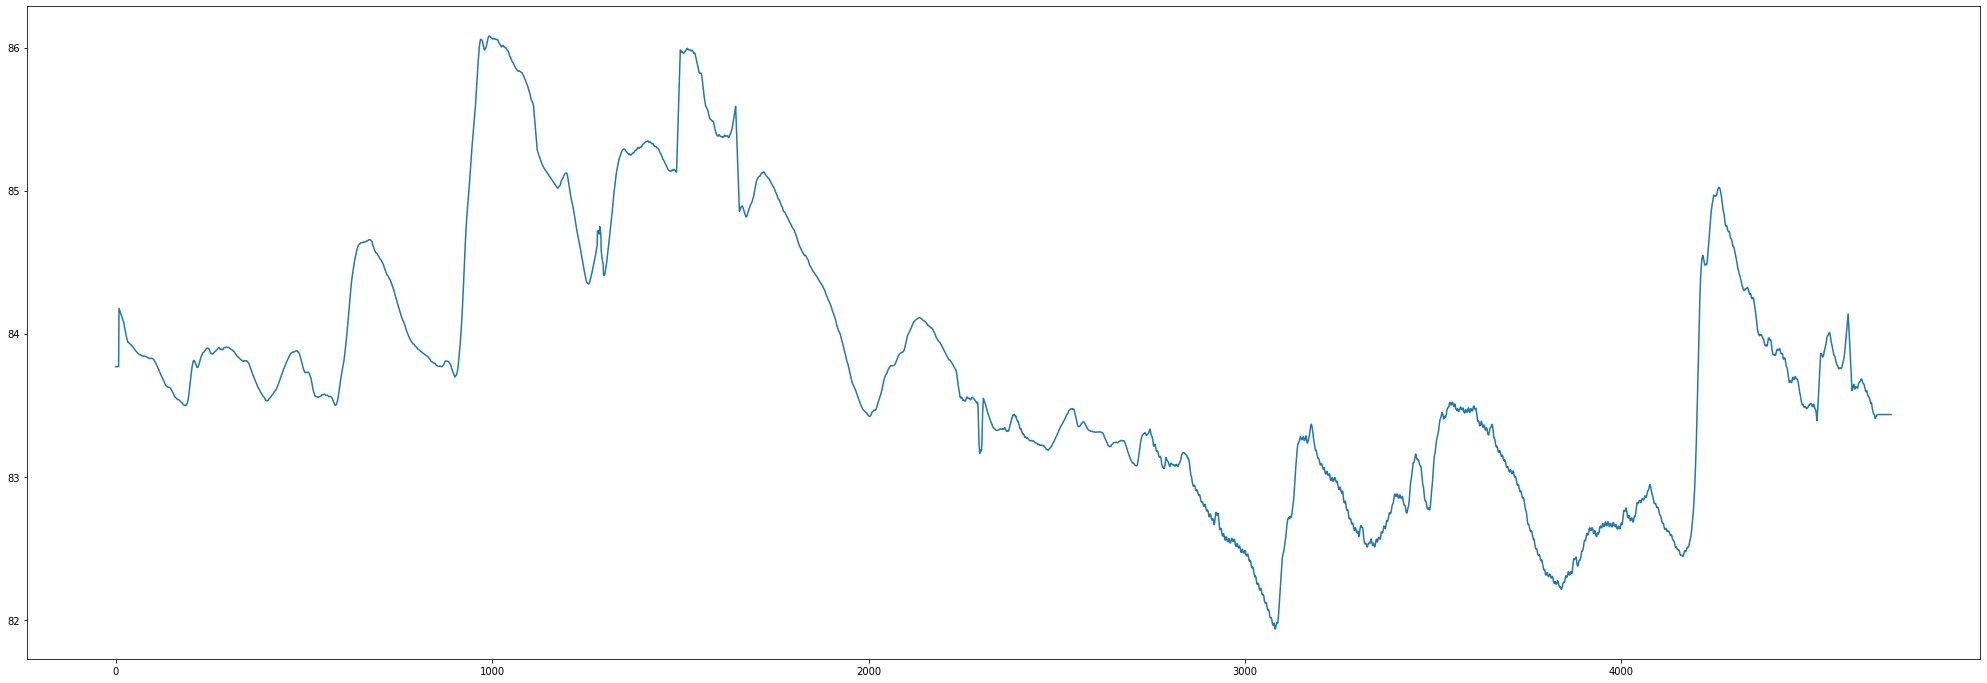

In [ ]:
df = pd.read_csv(args.root_path+ '/'+args.data_path)
%matplotlib inline 
mpl.rcParams['figure.figsize'] = (35,12)
mpl.rcParams['axes.grid'] = False
df['OBSR_DTA_VALUE'].plot()

Use GPU: cuda:0
>>>>>>>start training : (음성대소)UGW_train_20220824_FIX(i56o5ma10)_01(base)_DLinear_custom_ftMS_sl56_ll1_pl5_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 3713
val 469
test 467
	iters: 100, epoch: 1 | loss: 0.0024147
	speed: 0.0310s/iter; left time: 2299.6114s
	iters: 200, epoch: 1 | loss: 0.0056114
	speed: 0.0044s/iter; left time: 326.1681s
	iters: 300, epoch: 1 | loss: 0.0008667
	speed: 0.0048s/iter; left time: 355.4435s
	iters: 400, epoch: 1 | loss: 0.0118059
	speed: 0.0049s/iter; left time: 358.5589s
	iters: 500, epoch: 1 | loss: 0.0005954
	speed: 0.0049s/iter; left time: 360.5162s
	iters: 600, epoch: 1 | loss: 0.0008411
	speed: 0.0048s/iter; left time: 352.4048s
	iters: 700, epoch: 1 | loss: 0.0065915
	speed: 0.0049s/iter; left time: 358.4432s
Epoch: 1 cost time: 6.276057004928589
Epoch: 1, Steps: 742 | Train Loss: 0.0109289 Vali Loss: 0.0036682 Test Loss: 0.0031171
Validation loss decreased (inf --> 0.003668).  Saving model ...
Upd

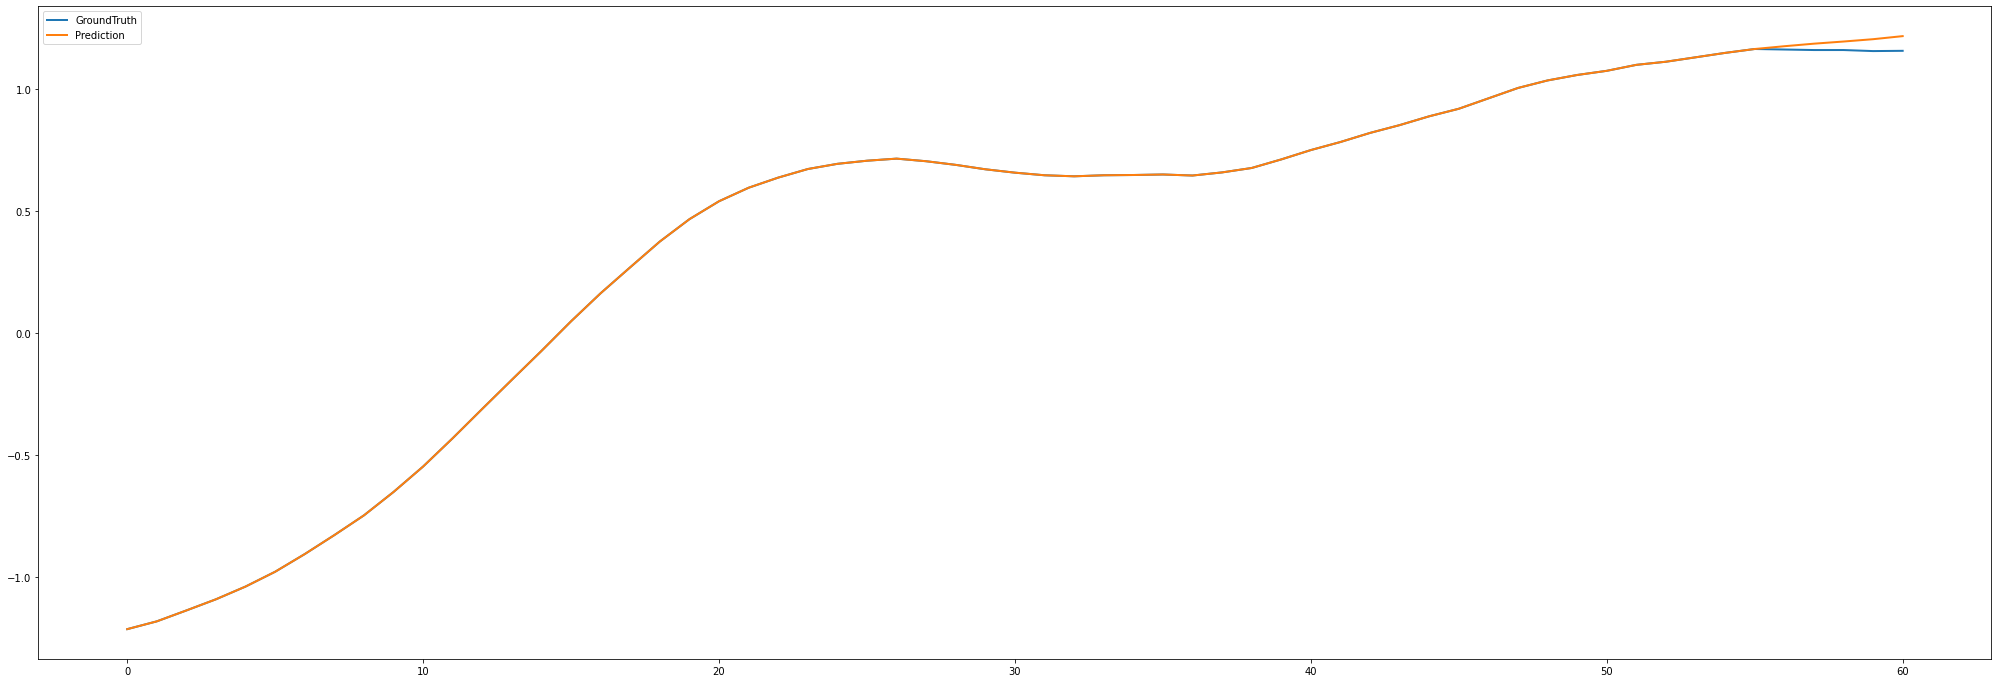

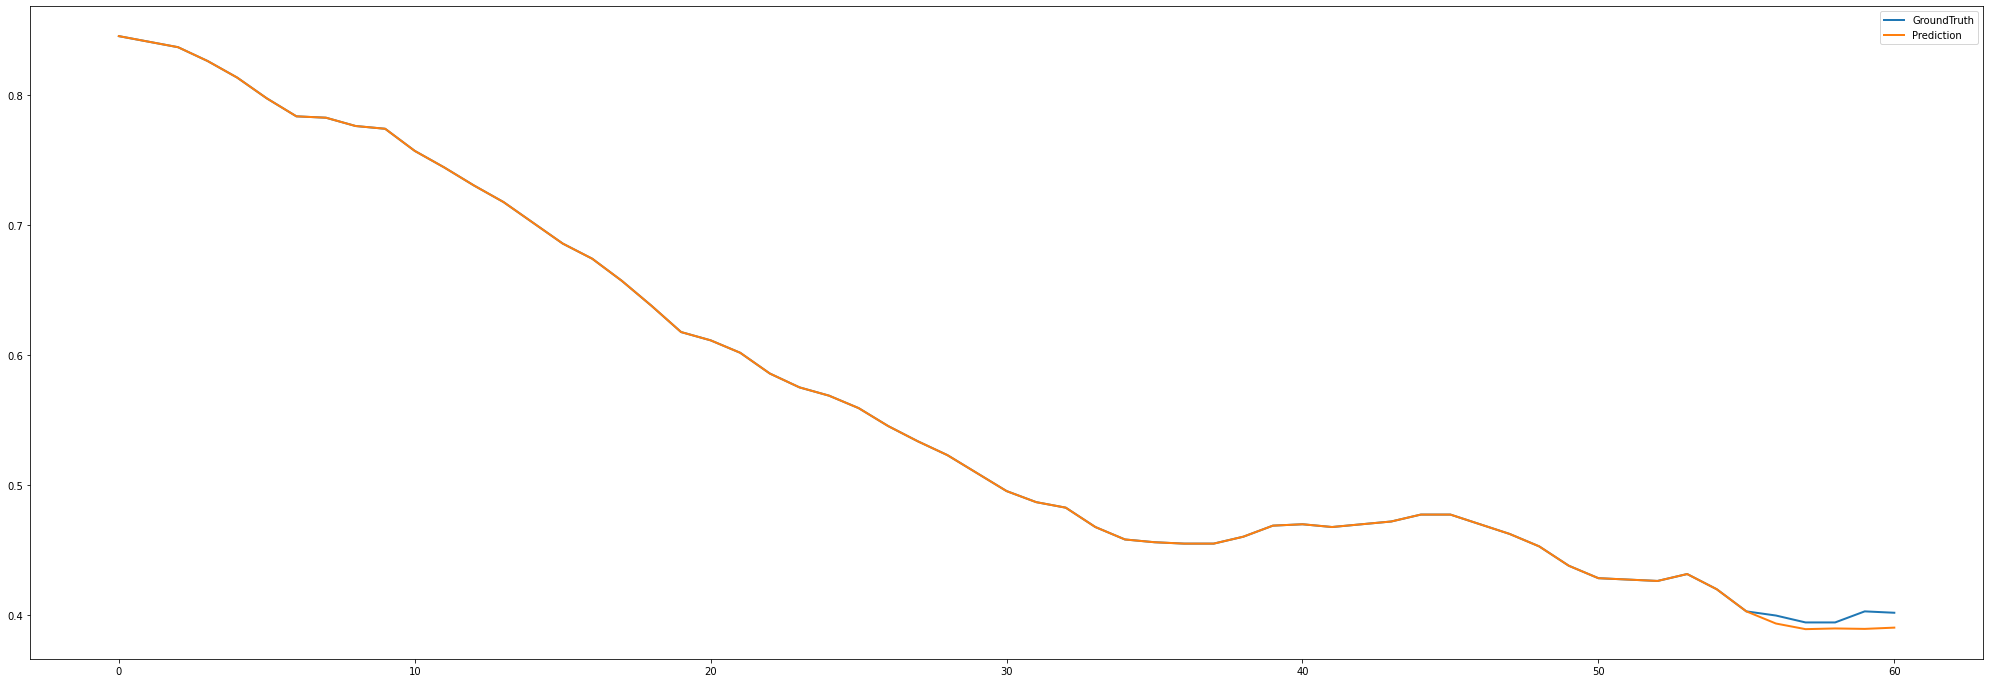

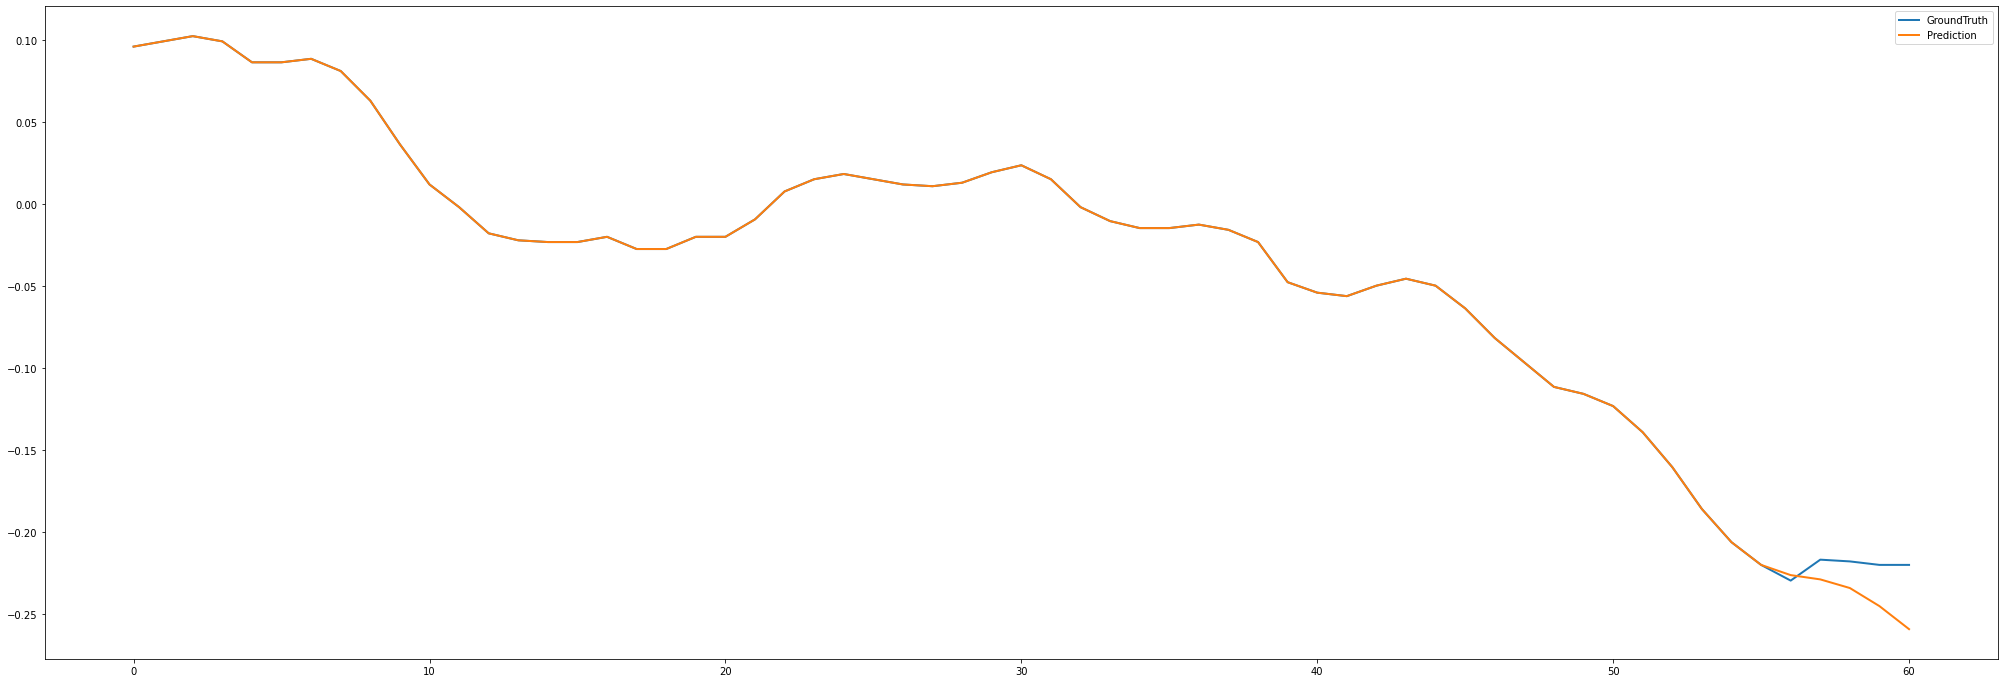

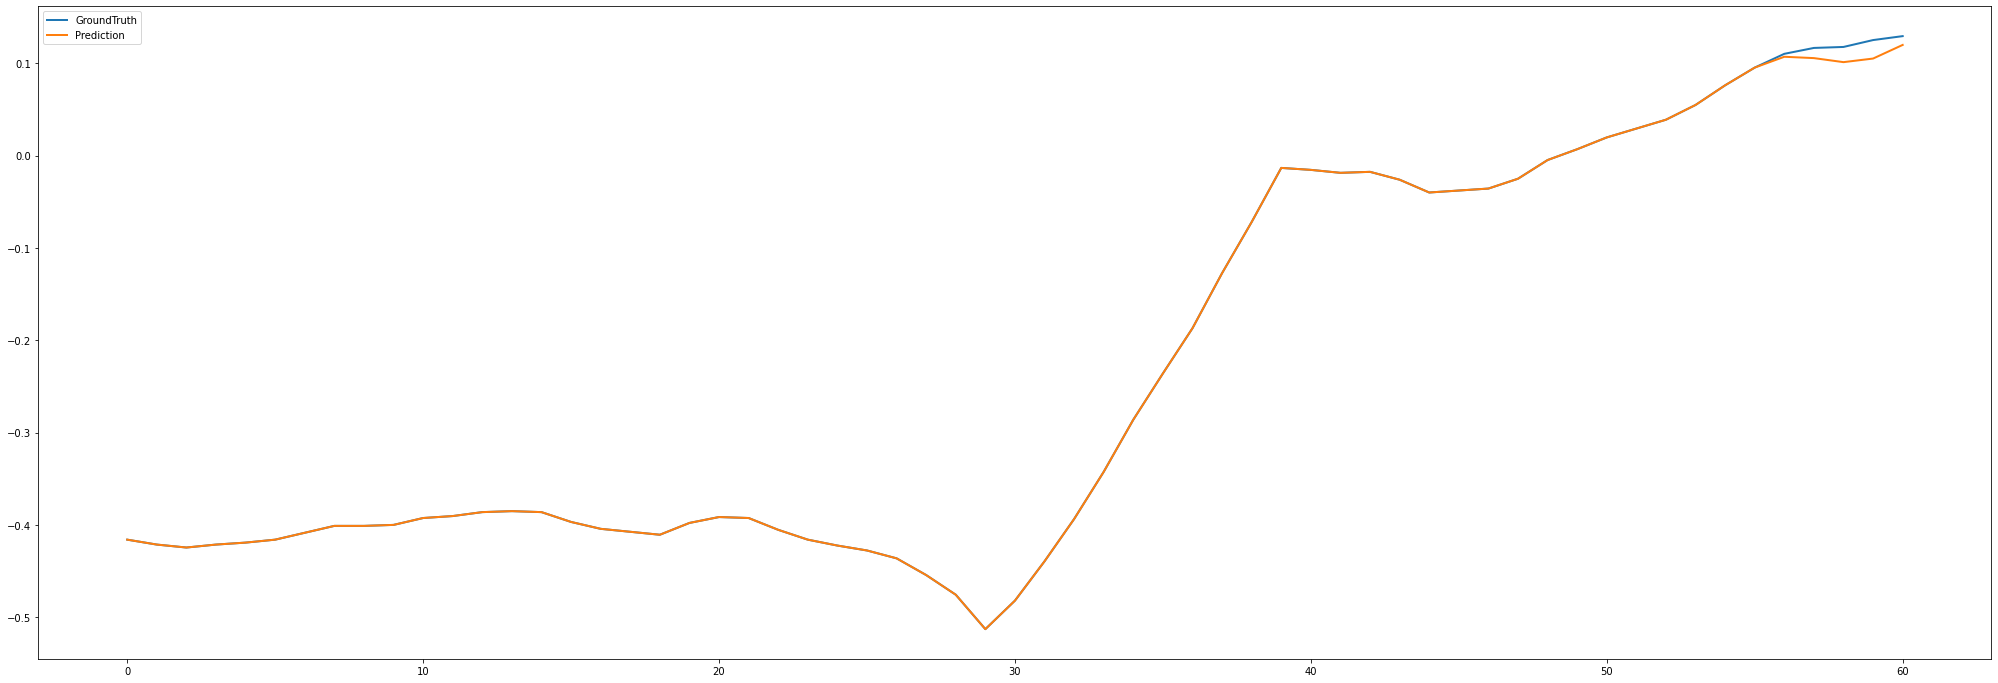

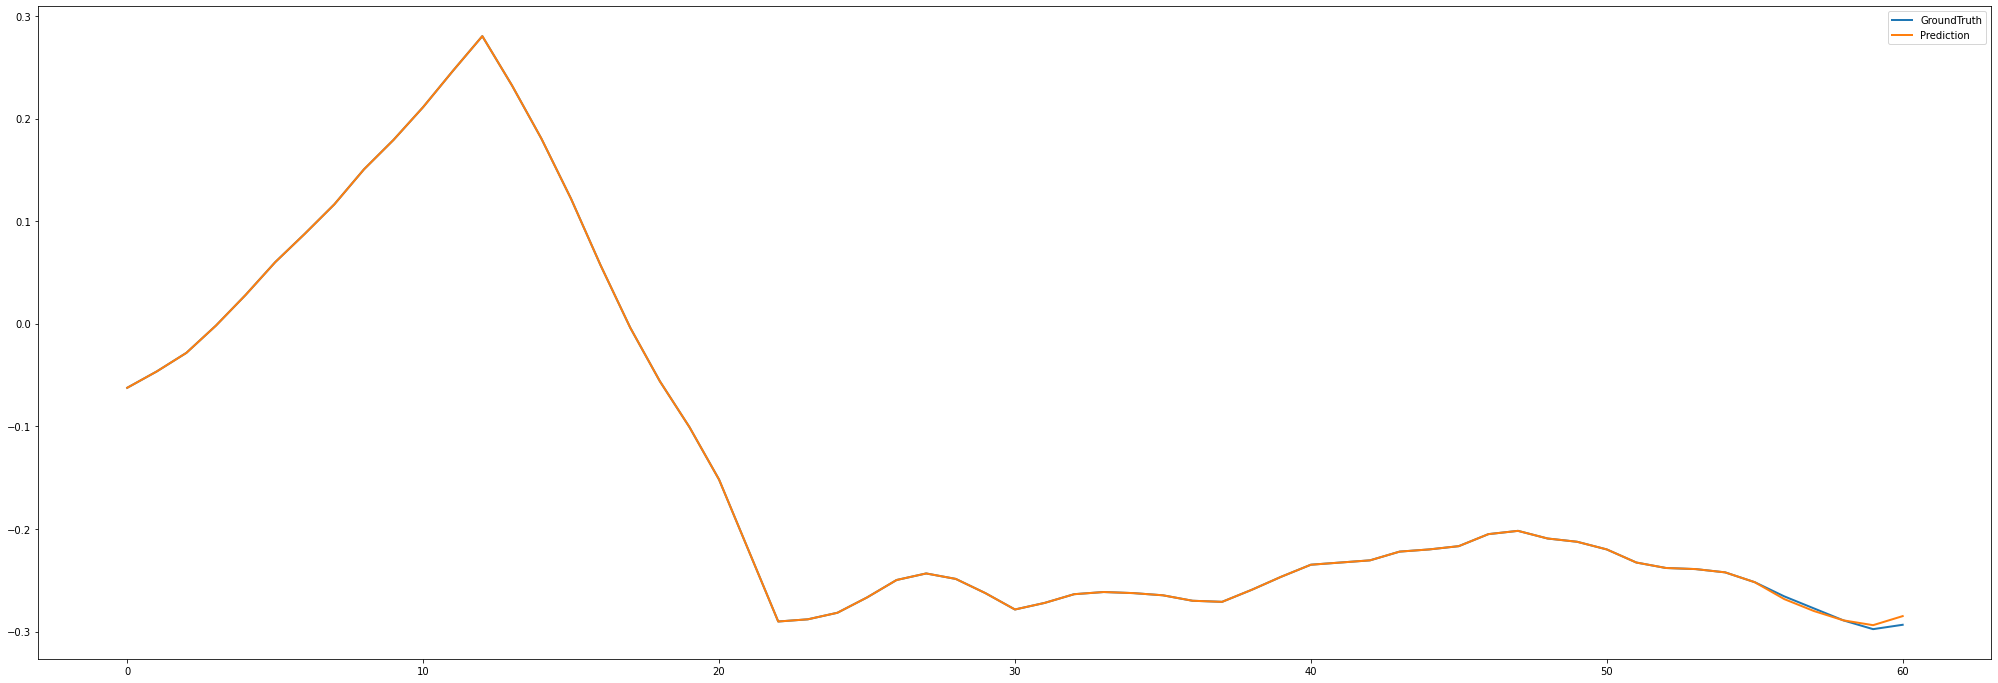

In [ ]:

Exp = Exp_Main

if args.is_training:
    for ii in range(args.itr):
        # setting record of experiments
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.factor,
            args.embed,
            args.distil,
            args.des, ii)

        exp = Exp(args)  # set experiments
        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
        exp.train(setting)

        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.test(setting)

        if args.do_predict:
            print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
            exp.predict(setting, True)

        torch.cuda.empty_cache()
else:
    ii = 0
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(args.model_id,
                                                                                                  args.model,
                                                                                                  args.data,
                                                                                                  args.features,
                                                                                                  args.seq_len,
                                                                                                  args.label_len,
                                                                                                  args.pred_len,
                                                                                                  args.d_model,
                                                                                                  args.n_heads,
                                                                                                  args.e_layers,
                                                                                                  args.d_layers,
                                                                                                  args.d_ff,
                                                                                                  args.factor,
                                                                                                  args.embed,
                                                                                                  args.distil,
                                                                                                  args.des, ii)

    exp = Exp(args)  # set experiments
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting, test=1)
    torch.cuda.empty_cache()


In [ ]:
# Result Plot
# result_path = '/content/drive/MyDrive/NIA 2차 수질예측 프로젝트/dev-models/DLinear/results/' + setting + '/'
result_path = '/content/drive/MyDrive/NIA 2차 수질예측 프로젝트/dev-models/DLinear/results/' + args.model_id + '/'
predict = np.load(osp.join(result_path, '음성대소_DLin_pred.npy'), allow_pickle=True)
true_y = np.load(osp.join(result_path, '음성대소_DLin_trues.npy'), allow_pickle=True)
input_x = np.load(osp.join(result_path, '음성대소_DLin_inputs.npy'), allow_pickle=True)
metric = np.load(osp.join(result_path, '음성대소_DLin_metrics.npy'), allow_pickle=True)
# x_mark = np.load(osp.join(result_path, 'x_mark.npy'), allow_pickle=True)
# y_mark = np.load(osp.join(result_path, 'y_mark.npy'), allow_pickle=True)

# base_data
umsung_df = pd.read_csv('/content/drive/MyDrive/NIA 2차 수질예측 프로젝트/원천데이터/(지하수) 전처리, 원천데이터 통합본/test_음성대소_기상자료_수위pre_20220805.csv')
umsung_df.columns = ['date','OBSR_DTA_VALUE','temp(°C)','rain(mm)','avg hum%)','avg local_hPa(hPa)','day_sum sunnshine(hr)']

# ['mae', 'mse', 'rmse', 'mape', 'mspe', 'rse', 'corr']
metric

true_step = umsung_df.iloc[4206:,:]
train_step = umsung_df.iloc[0:3739,1:]
train_mean = train_step.mean()
train_std = train_step.std() + 0.00000001
idx_l = [10, 20, 50, 160,170,180,230,260,320,340] # total idx 464

plot idx : 10


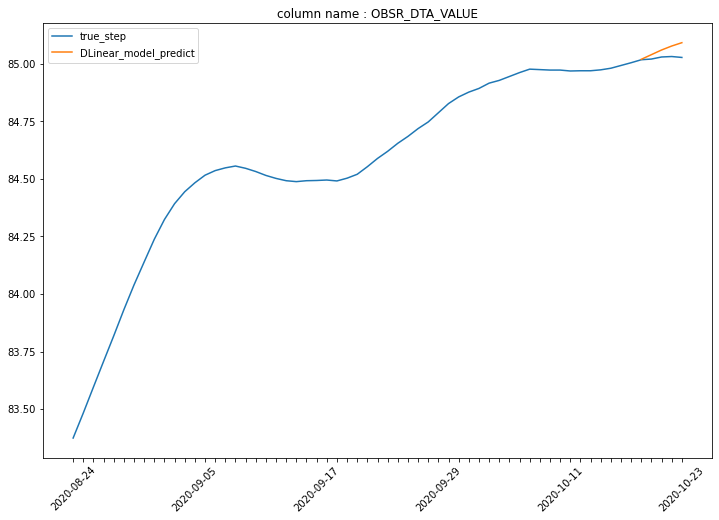

plot idx : 20


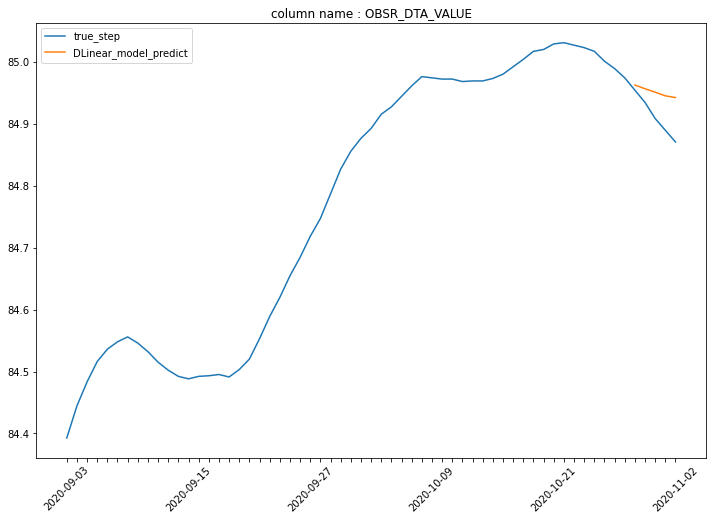

plot idx : 50


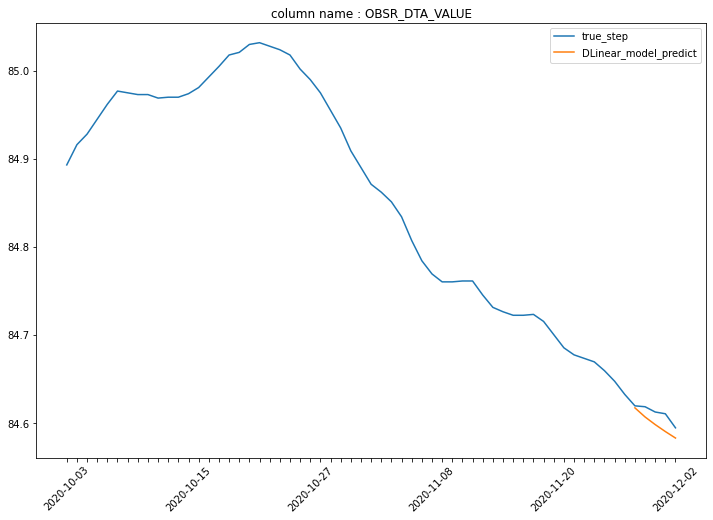

plot idx : 160


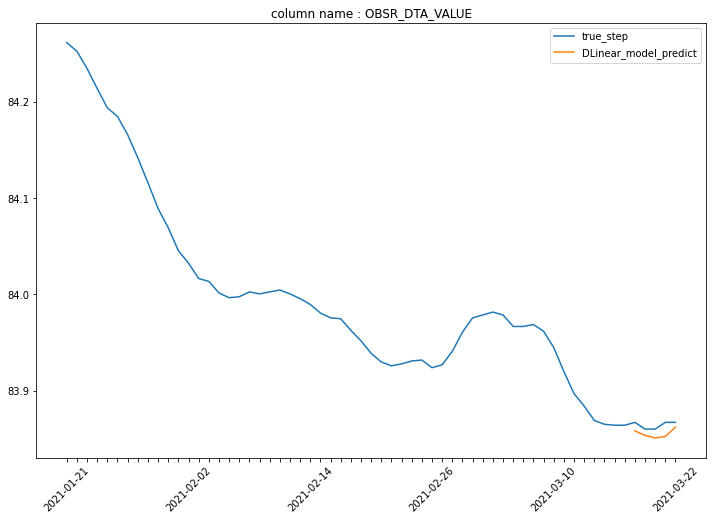

plot idx : 170


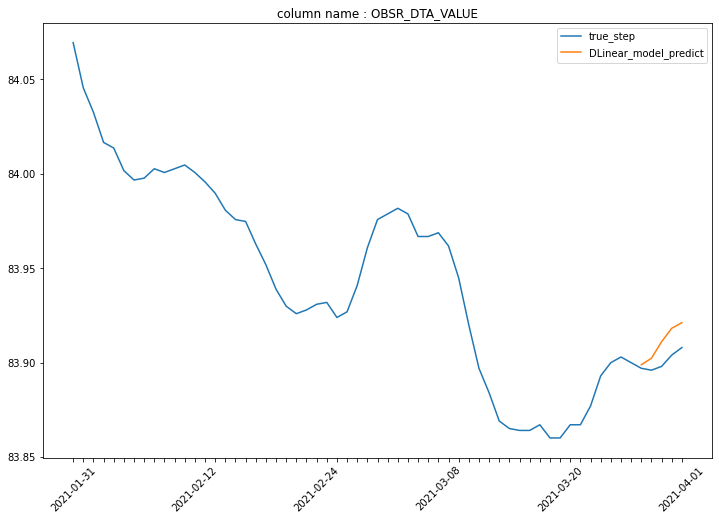

plot idx : 180


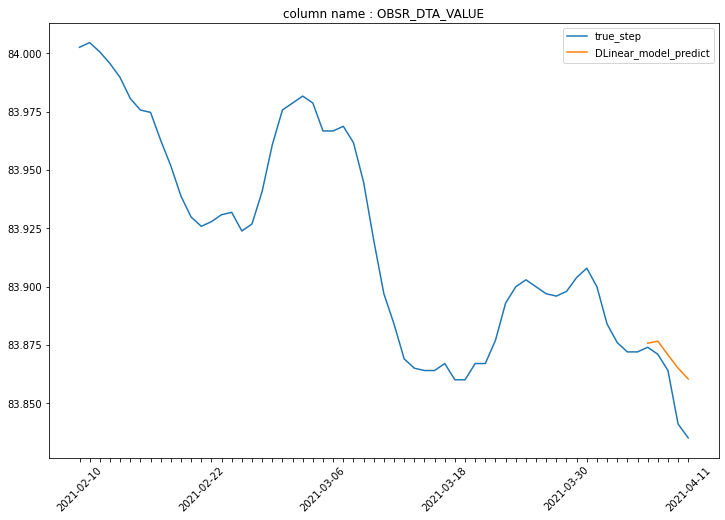

plot idx : 230


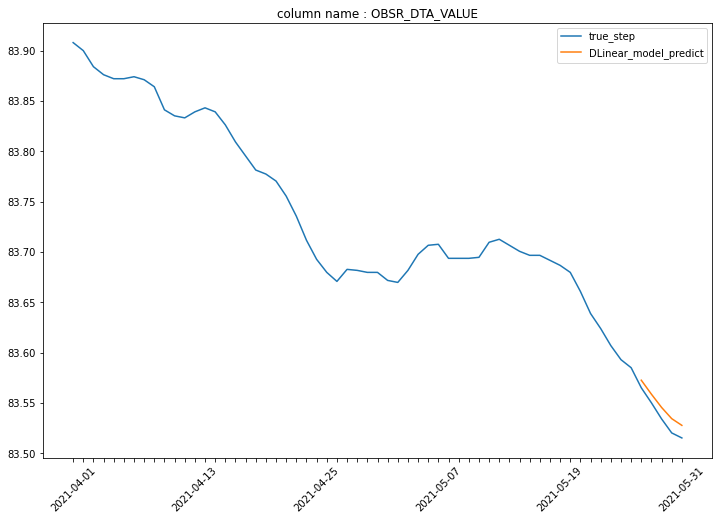

plot idx : 260


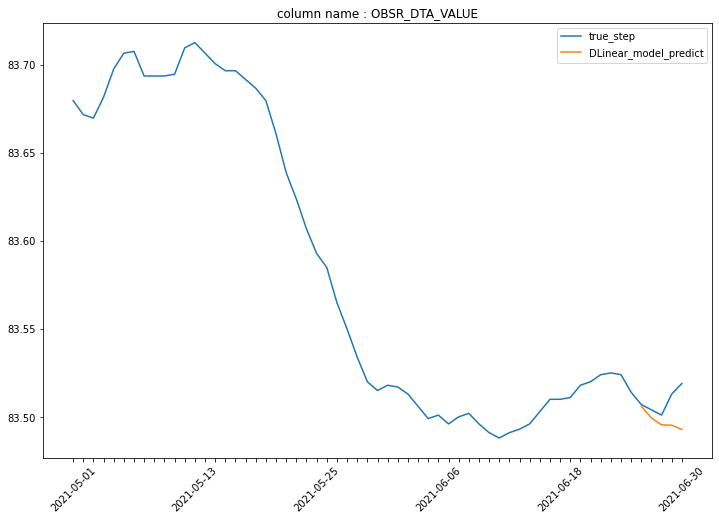

plot idx : 320


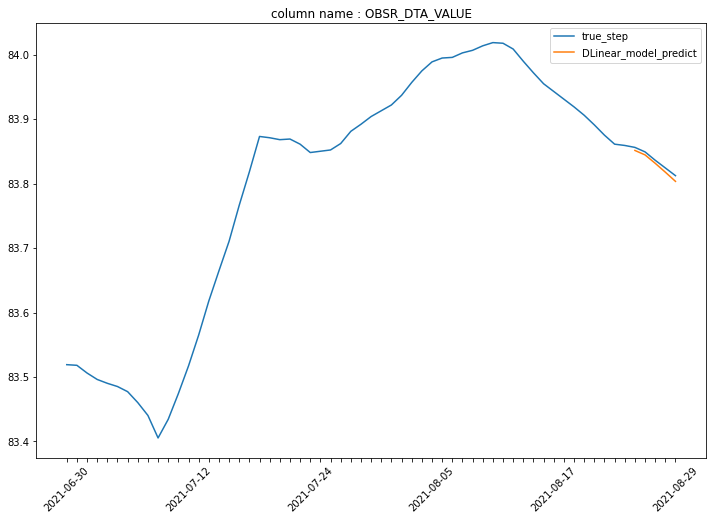

plot idx : 340


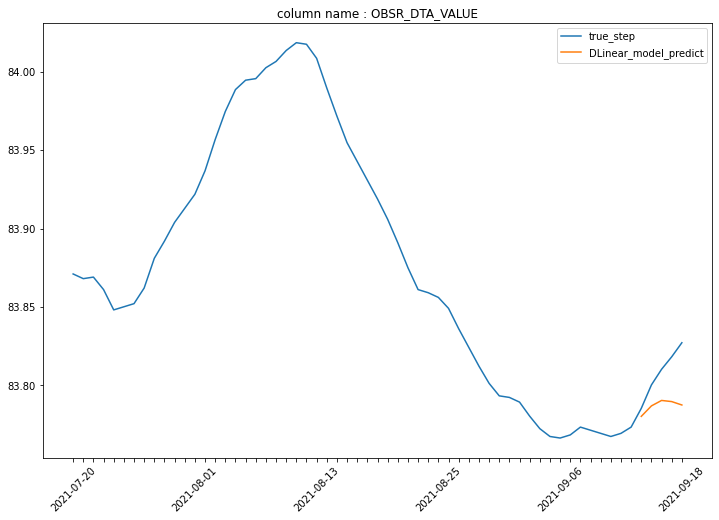

In [ ]:

img_path = '/content/drive/MyDrive/NIA 2차 수질예측 프로젝트/dev-models/DLinear/results/img2/'+args.model_id+'__'

seq = 5
input_step = 56
col = 0
colname = ['OBSR_DTA_VALUE']#,'temp(°C)','rain(mm)','avg hum%)','avg local_hPa(hPa)','sum sunny(hr)']

%matplotlib inline

for idx in idx_l:
# for idx in range(400):
  print(f"plot idx : {idx}")
  # input = pd.DataFrame(input_x[idx,:,-1:], columns = colname)
  # pred =  pd.DataFrame(predict[idx,:,:], columns = colname)
  # true =  pd.DataFrame(true_y[idx,:,:], columns = colname)


  input = pd.DataFrame(input_x[idx,:,-1:], columns = colname)
  pred =  pd.DataFrame(predict[idx,:,-1:], columns = colname)
  true =  pd.DataFrame(true_y[idx,:,-1:], columns = colname)

  input_scale = (input*train_std[0]) + train_mean[0]
  pred_scale = (pred*train_std[0]) +train_mean[0]
  true_scale = (true*train_std[0]) +train_mean[0]

  column = colname[0]
  fig, ax=plt.subplots(figsize=(12, 8))
  y_true = pd.concat([input_scale, true_scale],ignore_index=True)
  # y_true = pd.concat([input, true],ignore_index=True)
  y_true.index = true_step['date'][idx:idx+ input_step + seq]
  ax.plot(y_true[column], label='true_step')
  # pred.index = true_step['date'][idx+input_step:idx+ input_step + seq]
  # ax.plot(pred[column], label='DLinear_model_predict')
  pred_scale.index = true_step['date'][idx+input_step:idx+ input_step + seq]
  ax.plot(pred_scale[column], label='DLinear_model_predict')
  plt.title(f'column name : {column}')
  plt.xticks(rotation=45)
  for i, tick in enumerate(ax.xaxis.get_ticklabels()):
   if i % 12 != 0:
        tick.set_visible(False)
  ax.legend()
  plt.show()
  # plt.savefig(osp.join(img_path + str(idx) + '.png')) #, bbox_inches='tight')


In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import *

#prepare
result = predict.squeeze()
label = true_y.squeeze()
# print(result.shape, label.shape)

result_scale = (result*train_std[0]) +train_mean[0]
label_scale = (label*train_std[0]) +train_mean[0]

diff = 2
bk = []

#corr
sumout = 0
for id in range(result.shape[0]-diff):
  if id in bk:
    pass
  else:
    out,_ = pearsonr(label[id,:],result[id,:])
    sumout += out
# corr =  sumout/result.shape[0]
corr =  sumout/(result.shape[0]-diff)
print(f"corr : {corr}")

#MAE
# MAE = mean_absolute_error(label, result)
sumout = 0
for id in range(result.shape[0]-diff):
  if id in bk:
    pass
  else:
    out = mean_absolute_error(label[id,:],result[id,:])
    sumout += out
MAE = sumout/(result.shape[0]-diff)
print(f"MAE : {MAE}")

#MSE
sumout = 0
for id in range(result.shape[0]-diff):
  if id in bk:
    pass
  else:
    out = mean_squared_error(label[id,:],result[id,:])
    sumout += out
MSE =  sumout/(result.shape[0]-diff)
print(f"MSE : {MSE}")

# RMSE (Root Mean Squared Error)
sumout = 0
for id in range(result.shape[0]-diff):
  if id in bk:
    pass
  else:
    out = mean_squared_error(label[id,:],result[id,:])
    sumout += np.sqrt(out)
RMSE =  sumout/(result.shape[0]-diff)
print(f"RMSE : {RMSE}")

#MAPE (Mean Absolute Percentage Error)
sumout = 0
for id in range(result.shape[0]-diff):
  if id in bk:
    pass
  else:  
    out = np.mean(np.abs((label_scale[id,:] - result_scale[id,:]) / label_scale[id,:])) * 100 
    sumout += out
MAPE = sumout/(result.shape[0]-diff)
print(f"MAPE : {MAPE}")


corr : nan
MAE : 0.017271672419375956
MSE : 0.0009607001662851681
RMSE : 0.020040964521417397
MAPE : 0.019268815198632046


In [ ]:
def pearson_similarity(a, b):
    return np.dot((a - np.mean(a)), (b - np.mean(b))) / ((np.linalg.norm(a - np.mean(a))) * (np.linalg.norm(b - np.mean(b))))

In [ ]:
diff = 0
bk = []

#corr - pearson_corr module _ scipy.stats
sumout = 0
for id in range(result.shape[0]-diff):
  if id in bk:
    pass
  else:
    out,_ = pearsonr(label[id,:],result[id,:])
  print(f"id: {id}, out: {out}")
  sumout += out
corr =  sumout/(result.shape[0]-diff)
print(f"corr : {corr}")

id: 0, out: -0.8888989878077675
id: 1, out: -0.6746317597535878
id: 2, out: 0.29455535421683043
id: 3, out: 0.4519890082846809
id: 4, out: -0.9902995255557823
id: 5, out: -0.9906156765430478
id: 6, out: -0.9342447224106644
id: 7, out: -0.7050269294611593
id: 8, out: 0.9320745822533112
id: 9, out: 0.9621701117152424
id: 10, out: 0.8499430847288327
id: 11, out: 0.2618319267979907
id: 12, out: -0.8489452132775378
id: 13, out: -0.816784416025077
id: 14, out: 0.9179297009146438
id: 15, out: 0.9949666445838349
id: 16, out: 0.9781629250350218
id: 17, out: 0.9523890712014127
id: 18, out: 0.9735318666037943
id: 19, out: 0.9969192795026434
id: 20, out: 0.9954981977094791
id: 21, out: 0.9949145375799437
id: 22, out: 0.9859140212319015
id: 23, out: 0.996373415943609
id: 24, out: 0.9776028595774661
id: 25, out: 0.9895840599383935
id: 26, out: 0.999267075504041
id: 27, out: 0.9987695838357284
id: 28, out: 0.9982443296392676
id: 29, out: 0.9217096427379635
id: 30, out: 0.6137218435678566
id: 31, out:

In [ ]:
#corr - pearson_similarity function
sumout = 0
for id in range(result.shape[0]-diff):
    if id in bk:
      pass
    else:  
      out = pearson_similarity(label[id],result[id])
    print(f"id: {id}, out: {out}")
    sumout += out
# print(f"id: {id}, sumout: {sumout}")
corr =  sumout/(result.shape[0]-diff)
# corr =  sumout.mean()
print(f"corr : {corr}")

In [ ]:
from scipy.stats import pearsonr, tstd
from sklearn.metrics import *

def pearson_similarity(a, b):
    return np.dot((a - np.mean(a)), (b - np.mean(b))) / ((np.linalg.norm(a - np.mean(a))) * (np.linalg.norm(b - np.mean(b))))

args.model_id = '(음성대소)UGW_train_20220824_FIX(i56o5ma10)_01(base)' 
args.root_path = '/content/drive/MyDrive/NIA 2차 수질예측 프로젝트/원천데이터/(지하수) 전처리, 원천데이터 통합본'  # 'root path of the data file'
args.data_path = 'test_음성대소_기상자료_수위pre_20220805.csv'  

# result_path = '/content/drive/MyDrive/NIA 2차 수질예측 프로젝트/dev-models/DLinear/results/' + args.model_id + '/'
# predict = np.load(osp.join(result_path, '음성대소_DLin_pred.npy'), allow_pickle=True)
# true_y = np.load(osp.join(result_path, '음성대소_DLin_trues.npy'), allow_pickle=True)
# input_x = np.load(osp.join(result_path, '음성대소_DLin_inputs.npy'), allow_pickle=True)

#prepare
result = predict.squeeze()
label = true_y.squeeze()
print(f"shape: predict {result.shape}, ture {label.shape}\n")
print(f"dtype: predict {type(result)}, ture {type(label)}\n")

result_scale = (result*train_std[0]) +train_mean[0]
label_scale = (label*train_std[0]) +train_mean[0]
print(f"scale shape: predict {result.shape}, ture {label.shape}\n")

idx = 432

print(f"idx shape: predict {result[idx].shape}, ture {label[idx].shape}\n")

print(f"compare-data-index:{idx}")
print(f"predict : {result[idx]}")
print(f"true : {label[idx]}\n")
print(f"predict-mean: {np.mean(result[idx])}")
print(f"true-mean: {np.mean(label[idx])}\n")
print(f"predict-std: {result[idx].std()}")
print(f"true-std: {label[idx].std()}\n")

ps_corr = pearson_similarity(result[idx],label[idx])
print(f"custom_func_pearson_corr: {ps_corr}")
sps_corr = pearsonr(result[idx],label[idx])
print(f"scipy_func_pearson_corr: {sps_corr}\n")


shape: predict (465, 5), ture (465, 5)

dtype: predict <class 'numpy.ndarray'>, ture <class 'numpy.ndarray'>

scale shape: predict (465, 5), ture (465, 5)

idx shape: predict (5,), ture (5,)

compare-data-index:432
predict : [-0.4729461  -0.47269154 -0.4754543  -0.47698322 -0.47936976]
true : [-0.47119057 -0.46799687 -0.46799687 -0.46799687 -0.46799687]

predict-mean: -0.47548896074295044
true-mean: -0.468635618686676

predict-std: 0.002513416111469269
true-std: 0.0012774824863299727

custom_func_pearson_corr: -0.5058608055114746
scipy_func_pearson_corr: (-0.5058608010859242, 0.38455245200351257)



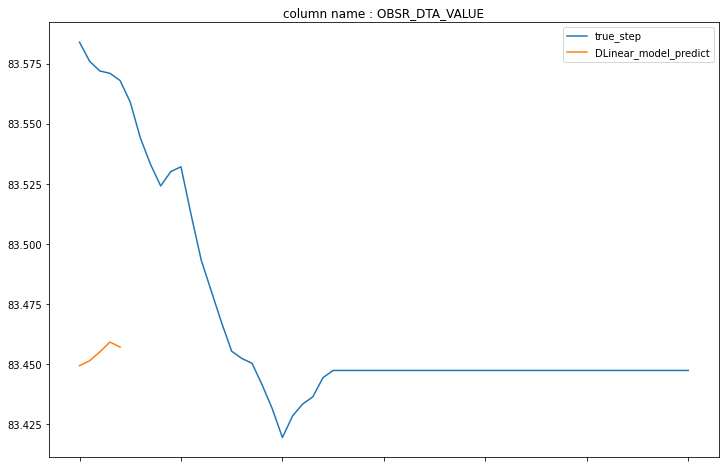

In [ ]:
idx = 464

# print(f"plot idx : {idx}")

input = pd.DataFrame(input_x[idx,:,-1:], columns = colname)
pred =  pd.DataFrame(predict[idx,:,:], columns = colname)
true =  pd.DataFrame(true_y[idx,:,:], columns = colname)

input_scale = (input*train_std[0]) + train_mean[0]
pred_scale = (pred*train_std[0]) +train_mean[0]
true_scale = (true*train_std[0]) +train_mean[0]

column = colname[0]
fig, ax=plt.subplots(figsize=(12, 8))
y_true = pd.concat([input_scale, true_scale],ignore_index=True)
# y_true = pd.concat([input, true],ignore_index=True)
# y_true.index = true_step['date'][idx:idx+ input_step + seq]
ax.plot(y_true[column], label='true_step')
# pred.index = true_step['date'][idx+input_step:idx+ input_step + seq]
# ax.plot(pred[column], label='DLinear_model_predict')
# pred_scale.index = true_step['date'][idx+input_step:idx+ input_step + seq]
ax.plot(pred_scale[column], label='DLinear_model_predict')
plt.title(f'column name : {column}')
plt.xticks(rotation=45)
for i, tick in enumerate(ax.xaxis.get_ticklabels()):
  if i % 12 != 0:
      tick.set_visible(False)
ax.legend()